<a href="https://colab.research.google.com/github/diegomartinmendez/CEIA_PLN_1/blob/main/Desafio_3_Diego_Mendez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facultad de Ingeniería - Universidad de Buenos Aires
## Laboratorio de Sistemas Embebidos
## Carrera de Especialización en Inteligencia Artificial
## Procesamiento Natual del Lenguaje I
### 2° Bimestre 2025 - Cohorte 17
### Mg. Ing. Diego Martín Méndez

## Desafío 3

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Carga de Datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pdf_path = "/content/drive/MyDrive/Desafios_PNL1/Horacio Quiroga - Anaconda.pdf"

In [4]:
import os

print("¿Existe el archivo?", os.path.exists(pdf_path))

¿Existe el archivo? True


In [5]:
!pip install pdfplumber

import pdfplumber

pdf_path = "/content/drive/MyDrive/Desafios_PNL1/Horacio Quiroga - Anaconda.pdf"

# Leer el PDF y extraer el texto
full_text = ""
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            full_text += text + "\n"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.3 MB/s eta 0:00:00


In [6]:
# Limpio el texto, sacando el encabezado y el final del texto que no pertenecen al cuento,
# también los números de página y de capítulo, dado que traen ruido al análisis:

import re

# Paso 1: Cortar desde donde empieza el cuento
start_marker = "http://www.textos.info"
start_idx = full_text.find(start_marker)

# Si no lo encuentra, usar desde el principio
if start_idx != -1:
    trimmed_text = full_text[start_idx + len(start_marker):]
else:
    trimmed_text = full_text

# Paso 2: Cortar justo antes de la línea con el número 45
lines = trimmed_text.splitlines()

cleaned_lines = []
for line in lines:
    stripped = line.strip()

    # Cortar si aparece la línea "45" sola
    if stripped == "45":
        break

    # Ignorar líneas que son solo números de página
    if stripped.isdigit():
        continue

    # Ignorar números romanos tipo "I", "XIV", etc.
    if re.fullmatch(r'[IVXLCDM]+', stripped):
        continue

    # Agregar líneas válidas
    cleaned_lines.append(line)

# Reconstruir el texto final
final_text = "\n".join(cleaned_lines)

# Normalizar saltos de línea múltiples
final_text = re.sub(r'\n{3,}', '\n\n', final_text).strip()


In [7]:
# Verifico que el texto quedó limpio:

print("--- Inicio ---\n")
print(final_text[:1000])

--- Inicio ---

Eran las diez de la noche y hacía un calor sofocante. El tiempo cargado
pesaba sobre la selva, sin un soplo de viento. El cielo de carbón se
entreabría de vez en cuando en sordos relámpagos de un extremo a otro
del horizonte; pero el chubasco silbante del sur estaba aún lejos.
Por un sendero de vacas en pleno espartillo blanco, avanzaba Lanceolada,
con la lentitud genérica de las víboras. Era una hermosísima yarará, de un
metro cincuenta, con los negros ángulos de su flanco bien cortados en
sierra, escama por escama. Avanzaba tanteando la seguridad del terreno
con la lengua, que en los ofidios reemplaza perfectamente a los dedos.
Iba de caza. Al llegar a un cruce de senderos se detuvo, se arrolló
prolijamente sobre sí misma, removiose aún un momento acomodándose y
después de bajar la cabeza al nivel de sus anillos, asentó la mandíbula
inferior y esperó inmóvil.
Minuto tras minuto esperó cinco horas. Al cabo de este tiempo continuaba
en igual inmovilidad. ¡Mala noche! Co

In [8]:
print("\n--- Final ---\n")
print(final_text[-1000:])


--- Final ---

uevo director—. No es éste su
país. A lo que parece, ha trabado relación con la cobra real… y nos ha
vengado a su manera. Si logramos salvarla haremos una gran cosa,
porque parece terriblemente envenenada. Llevémosla. Acaso un día nos
salve a nosotros de toda esta chusma venenosa.
Y se fueron, llevando de un palo que cargaban en los hombros, a
Anaconda, que, herida y exhausta de fuerzas, iba pensando en Ñacaniná,
cuyo destino, con un poco menos de altivez, podía haber sido semejante al
suyo.
Anaconda no murió. Vivió un año con los hombres, curioseando y
observándolo todo, hasta que una noche se fue. Pero la historia de este
viaje remontando por largos meses el Paraná hasta más allá del Guayra,
más allá todavía del golfo letal donde el Paraná toma el nombre de río
Muerto; la vida extraña que llevó Anaconda y el segundo viaje que
emprendió por fin con sus hermanos sobre las aguas sucias de una gran
inundación —toda esta historia de rebelión y asalto de camalotes,
pertenec

In [9]:
length = len(final_text)
length

60066

### Elegir el tamaño del contexto

In [10]:
# selecciono el tamaño de contexto:
max_context_size = 100

In [11]:
# Uso las utilidades de procesamiento de textos y secuencias de Keras:
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [12]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(final_text)

In [13]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

71

In [14]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

### Tokenizar

In [15]:
# tokenizamos el texto completo:
tokenized_text = [char2idx[ch] for ch in final_text]

In [16]:
tokenized_text[:1000]

[27,
 55,
 57,
 23,
 45,
 35,
 57,
 42,
 45,
 1,
 16,
 4,
 39,
 45,
 1,
 4,
 45,
 35,
 57,
 45,
 23,
 47,
 11,
 21,
 4,
 45,
 7,
 45,
 21,
 57,
 11,
 64,
 57,
 45,
 61,
 23,
 45,
 11,
 57,
 35,
 47,
 55,
 45,
 42,
 47,
 54,
 47,
 11,
 57,
 23,
 22,
 4,
 28,
 45,
 27,
 35,
 45,
 22,
 16,
 4,
 46,
 17,
 47,
 45,
 11,
 57,
 55,
 33,
 57,
 1,
 47,
 50,
 17,
 4,
 42,
 57,
 69,
 57,
 45,
 42,
 47,
 69,
 55,
 4,
 45,
 35,
 57,
 45,
 42,
 4,
 35,
 59,
 57,
 19,
 45,
 42,
 16,
 23,
 45,
 61,
 23,
 45,
 42,
 47,
 17,
 35,
 47,
 45,
 1,
 4,
 45,
 59,
 16,
 4,
 23,
 22,
 47,
 28,
 45,
 27,
 35,
 45,
 11,
 16,
 4,
 35,
 47,
 45,
 1,
 4,
 45,
 11,
 57,
 55,
 69,
 34,
 23,
 45,
 42,
 4,
 50,
 4,
 23,
 22,
 55,
 4,
 57,
 69,
 55,
 64,
 57,
 45,
 1,
 4,
 45,
 59,
 4,
 39,
 45,
 4,
 23,
 45,
 11,
 61,
 57,
 23,
 1,
 47,
 45,
 4,
 23,
 45,
 42,
 47,
 55,
 1,
 47,
 42,
 45,
 55,
 4,
 35,
 62,
 46,
 17,
 57,
 33,
 47,
 42,
 45,
 1,
 4,
 45,
 61,
 23,
 45,
 4,
 3,
 22,
 55,
 4,
 46,
 47,
 45,
 57,
 45,
 47,

### Organizando y estructurando el dataset

In [17]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [18]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [19]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [20]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [21]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [22]:
X.shape

(53866, 100)

In [23]:
X[0,:10]

array([27, 55, 57, 23, 45, 35, 57, 42, 45,  1])

In [24]:
y[0,:10]

array([55, 57, 23, 45, 35, 57, 42, 45,  1, 16])

In [25]:
vocab_size = len(chars_vocab)

## Definir el modelo

In [26]:
# Configuramos para usar GPU

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [27]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [28]:
model_simpleRNN = Sequential()

model_simpleRNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_simpleRNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_simpleRNN.add(Dense(vocab_size, activation='softmax'))
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simpleRNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        54,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 71)       │        14,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,671 (268.25 KB)

 Trainable params: 68,671 (268.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# LSTM
model_LSTM = Sequential()

model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_LSTM.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dense(vocab_size, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        68,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 71)       │         7,171 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,971 (296.76 KB)

 Trainable params: 75,971 (296.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# GRU
model_GRU = Sequential()

model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_GRU.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dense(vocab_size, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 71)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 100)      │        51,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 71)       │         7,171 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,071 (230.75 KB)

 Trainable params: 59,071 (230.75 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Entrenamiento

In [32]:
epochs = 20

In [33]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl_simpleRNN = []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val, history_ppl_simpleRNN, model_name='model_simpleRNN')], batch_size=256)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 3.0372
 mean perplexity: 11.357827186584473 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 104s 414ms/step - loss: 3.0358
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 2.3014
 mean perplexity: 9.559212684631348 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 137s 393ms/step - loss: 2.3012
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 2.1706
 mean perplexity: 8.611793518066406 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 80s 380ms/step - loss: 2.1705
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 2.0922
 mean perplexity: 8.26205825805664 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 84s 389ms/step - loss: 2.0921
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 2.0258
 mean perplexity: 8.180904388427734 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 141s 385ms/step - loss: 2.0257
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 1.9657
 mean perplex

In [34]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM, model_name='model_LSTM')], batch_size=256)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 3.3092
 mean perplexity: 19.7356014251709 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 173s 772ms/step - loss: 3.3083
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - loss: 2.8634
 mean perplexity: 14.793069839477539 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 156s 741ms/step - loss: 2.8631
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - loss: 2.6216
 mean perplexity: 12.563961029052734 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 203s 747ms/step - loss: 2.6214
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - loss: 2.4823
 mean perplexity: 11.306098937988281 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 205s 760ms/step - loss: 2.4822
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - loss: 2.3889
 mean perplexity: 10.57365894317627 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 156s 741ms/step - loss: 2.3888
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - loss: 2.3248
 mean per

In [35]:
history_ppl_GRU = []
hist_GRU = model_GRU.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU, model_name='model_GRU')], batch_size=256)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 3.2868
 mean perplexity: 13.113889694213867 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 139s 623ms/step - loss: 3.2853
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - loss: 2.4834
 mean perplexity: 9.988473892211914 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 136s 597ms/step - loss: 2.4831
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - loss: 2.2893
 mean perplexity: 9.187134742736816 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 124s 590ms/step - loss: 2.2891
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 2.1845
 mean perplexity: 8.484956741333008 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 139s 572ms/step - loss: 2.1844
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 2.1025
 mean perplexity: 8.009227752685547 

Saved new model!
211/211 ━━━━━━━━━━━━━━━━━━━━ 143s 578ms/step - loss: 2.1025
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 2.0338
 mean perp

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_curve(history_ppl, model_name):
    """
    Grafica la curva de perplejidad durante el entrenamiento.

    Parámetros:
    - history_ppl: lista de valores de perplejidad por época
    - model_name: nombre del modelo (usado como título del gráfico)
    """
    sns.set_theme(style="whitegrid")

    epochs = list(range(1, len(history_ppl) + 1))

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=history_ppl, marker="o", color="red")

    # Etiquetas y título
    plt.title(f"Perplejidad por Epochs – {model_name}", fontsize=12, weight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Perplejidad", fontsize=12)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Anotar el último valor
    plt.annotate(f"{history_ppl[-1]:.2f}",
                 xy=(epochs[-1], history_ppl[-1]),
                 xytext=(epochs[-1], history_ppl[-1] * 1.05),
                 fontsize=10,
                 ha='center',
                 arrowprops=dict(arrowstyle="->", lw=1))

    plt.tight_layout()
    plt.show()

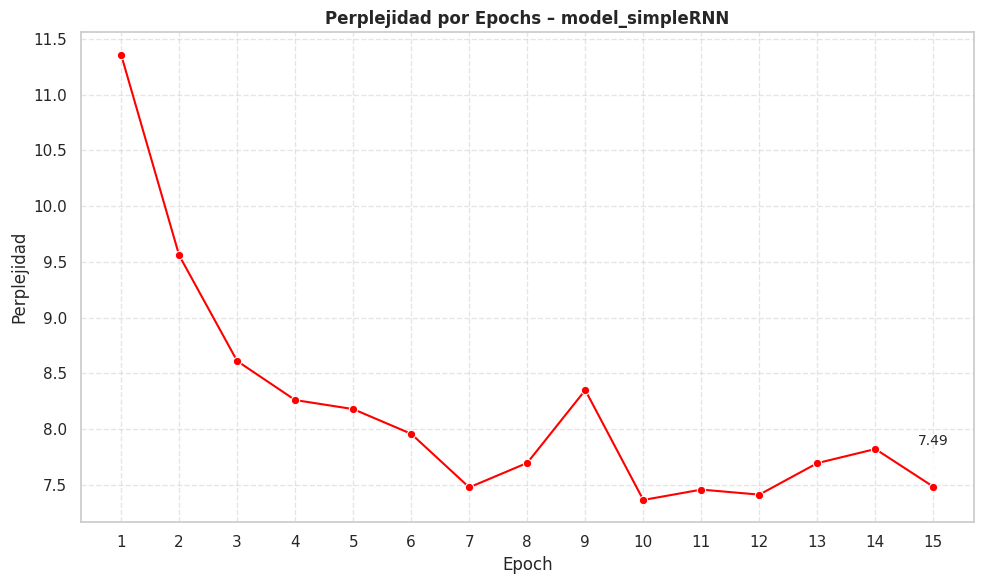

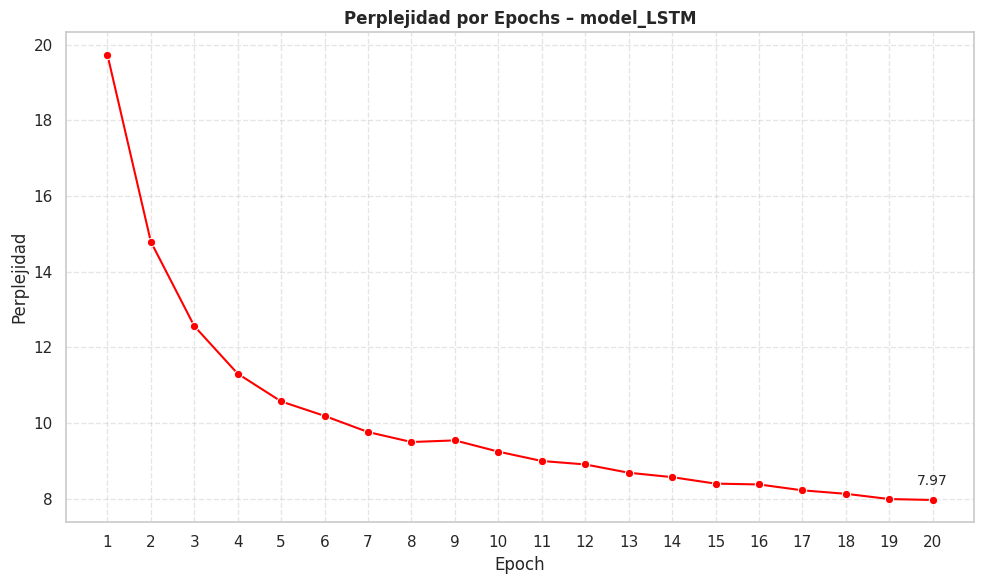

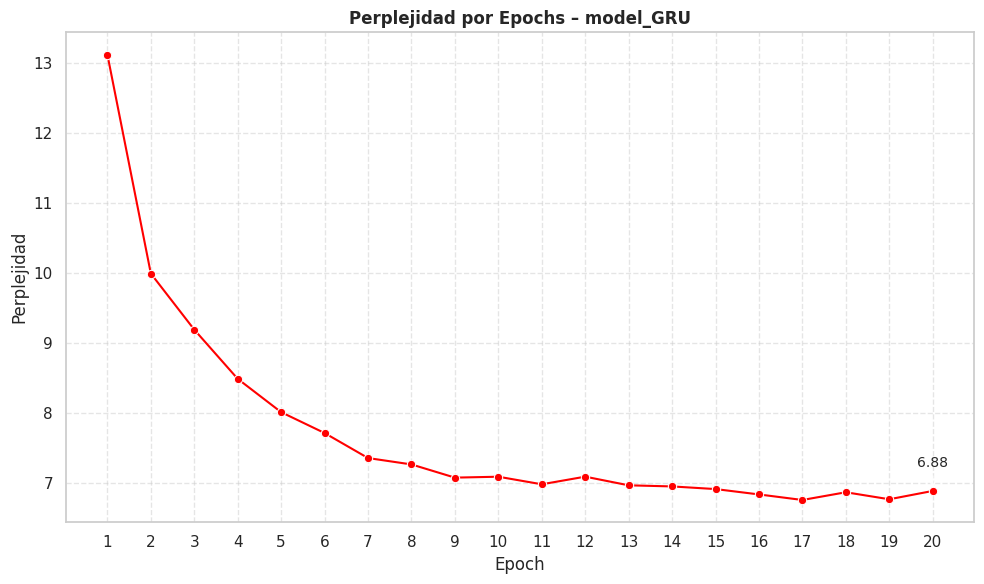

In [37]:
plot_training_curve(history_ppl_simpleRNN, "model_simpleRNN")
plot_training_curve(history_ppl_LSTM, "model_LSTM")
plot_training_curve(history_ppl_GRU, "model_GRU")

#### Conclusión del desempeño de los modelos

El modelo GRU tuvo la menor perplejidad, aunque al valor que llegó (6,88), ya estaba lateralizando. En cambio el modelo LSTM tiene una tendencia a la baja, así que si se hubiera siguido entrenando, quizás superaba al modelo GRU. El modelo SimpleRNN en cambio tuvo un desempeño errático.

### Predicción y pruebas de modelos

In [38]:
# Cargamos los mejores modelos guardados
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_GRU = keras.models.load_model('model_GRU.keras')

### Predicción de la próxima palabra

In [39]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [85]:
import gradio as gr

def model_response(human_text, model=model_GRU):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

In [86]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e4d92e7dcaa039f628.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e4d92e7dcaa039f628.gradio.live


In [89]:
text = "definitivament"
print(f'Respuesta SimpleRNN: {model_response(text, model_simpleRNN)}')
print(f'Respuesta LSTM: { model_response(text, model_LSTM) }')
print(f'Respuesta GRU: {model_response(text, model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Respuesta SimpleRNN: definitivamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Respuesta LSTM: definitivamente
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Respuesta GRU: definitivamente


### Generación de secuencias

### Greedy search

In [42]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [43]:
input_text='habia una vez'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

habia una vez al presenta de la cabeza de l
habia una vezada de la caballada de la caba
habia una vez de la cabeza de la cabeza de 


In [44]:
input_text='en esta ocasión funciona'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

en esta ocasión funciona al destonte de la cabeza de l
en esta ocasión funciona en esta a la caballa de la ca
en esta ocasión funciona la cabeza de la cabeza de la 


In [45]:
input_text='cuidado con la serpiente'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

cuidado con la serpiente de la cabeza de la cabeza de 
cuidado con la serpiente de la caballa de la caballada
cuidado con la serpiente de la cabeza de la cabeza de 


In [46]:
input_text='¿y ahora que pasa?'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

¿y ahora que pasa?
—¡Na aste la cabeza de la cab
¿y ahora que pasa? —reperto de la caballa de la 
¿y ahora que pasa? —repuso el perro de la cabeza


### Beam Search

In [73]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [77]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [78]:
def run_grid_search_beam():
    modelos = {
        'SimpleRNN': model_simpleRNN,
        'LSTM': model_LSTM,
        'GRU': model_GRU
    }

    temps = [1, 2, 3, 4, 5]
    modos = ['det', 'sto']

    resultados = []

    for nombre_modelo, modelo in modelos.items():
        for temp in temps:
            for mode in modos:
                print(f"▶ Ejecutando: Modelo={nombre_modelo}, temp={temp}, mode={mode}")
                salida = beam_search(
                    model=modelo,
                    num_beams=10,
                    num_words=30,
                    input="van caminando hacia el río",
                    temp=temp,
                    mode=mode
                )
                resultados.append({
                    "modelo": nombre_modelo,
                    "temp": temp,
                    "mode": mode,
                    "output": salida
                })
                print(decode(salida[0]))

    #return resultados


In [79]:
run_grid_search_beam()


▶ Ejecutando: Modelo=SimpleRNN, temp=1, mode=det
van caminando hacia el río contra las víboras, la cabeza
▶ Ejecutando: Modelo=SimpleRNN, temp=1, mode=sto
van caminando hacia el río contra de las víboras, la cal
▶ Ejecutando: Modelo=SimpleRNN, temp=2, mode=det
van caminando hacia el río contra las víboras, la cabeza
▶ Ejecutando: Modelo=SimpleRNN, temp=2, mode=sto
van caminando hacia el río coma se el sus destante segue
▶ Ejecutando: Modelo=SimpleRNN, temp=3, mode=det
van caminando hacia el río contra las víboras, la cabeza
▶ Ejecutando: Modelo=SimpleRNN, temp=3, mode=sto
van caminando hacia el ríotios! ¡Es másdosos… Por
cueda—
▶ Ejecutando: Modelo=SimpleRNN, temp=4, mode=det
van caminando hacia el río contra las víboras, la cabeza
▶ Ejecutando: Modelo=SimpleRNN, temp=4, mode=sto
van caminando hacia el río, migó, yala Cras… Magér aisa,
▶ Ejecutando: Modelo=SimpleRNN, temp=5, mode=det
van caminando hacia el río contra las víboras, la cabeza
▶ Ejecutando: Modelo=SimpleRNN, temp=5, mode=s

### Conclusión

Utilicé la técnica de beam search con num_beams = 10 y num_words = 30, variando dos parámetros clave:

- temp (temperatura): de 1 a 5

- mode: 'det' (determinístico) y 'sto' (estocástico)

Esto resultó en una grid search exhaustiva con 30 combinaciones por modelo.

Las temperaturas 1–2 producen salidas conservadoras, repetitivas.

Las temperaturas 4–5 inducen ruido, errores gramaticales y pérdida de contexto.

El modo 'sto' con temperatura intermedia permite una mayor creatividad sin sacrificar coherencia.

El modelo LSTM con temperatura 2–3 en modo estocástico fue el que logró mejores resultados subjetivos en cuanto a estilo y continuidad narrativa.

La elección del nivel de aleatoriedad (temp) es tan relevante como la arquitectura dado que no existe un buen modelo si se lo evalúa con una temperatura inadecuada.